In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [2]:
dataset_folder = "dataset/cleaned"
sensor_name = "Sensor 1"
save_folder = f"saved_model/{sensor_name}"

In [3]:
train_data = pd.read_csv(
    f"{dataset_folder}/train/{sensor_name}_train.csv"
)
val_data = pd.read_csv(
    f"{dataset_folder}/val/{sensor_name}_val.csv"
)
test_data = pd.read_csv(
    f"{dataset_folder}/test/{sensor_name}_test.csv"
)

train_data["created_at"] = pd.to_datetime(train_data["created_at"], format="ISO8601")
val_data["created_at"] = pd.to_datetime(val_data["created_at"], format="ISO8601")
test_data["created_at"] = pd.to_datetime(test_data["created_at"], format="ISO8601")

train_data.set_index("created_at", inplace=True)
val_data.set_index("created_at", inplace=True)
test_data.set_index("created_at", inplace=True)

In [4]:
train_data = train_data[['power']]
val_data = val_data[['power']]
test_data = test_data[['power']]

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [6]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [7]:
X_train, y_train = create_sequences(train_data_scaled, time_steps=24)
X_val, y_val = create_sequences(val_data_scaled, time_steps=24)
X_test, y_test = create_sequences(test_data_scaled, time_steps=24)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
# Define the LSTM model with modifications
model = Sequential()

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1))))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Additional LSTM Layer
model.add(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Final LSTM Layer
model.add(LSTM(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1))

# Compile the model with learning rate scheduler
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')

d:\Daffa Titip\power-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=24, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 669s 31ms/step - loss: 0.2611 - val_loss: 0.0039 - learning_rate: 1.0409e-04
Epoch 2/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 598s 28ms/step - loss: 0.0066 - val_loss: 0.0027 - learning_rate: 1.0834e-05
Epoch 3/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 621s 29ms/step - loss: 0.0064 - val_loss: 0.0020 - learning_rate: 1.1277e-06
Epoch 4/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 640s 30ms/step - loss: 0.0063 - val_loss: 0.0020 - learning_rate: 1.1739e-07
Epoch 5/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 644s 30ms/step - loss: 0.0063 - val_loss: 0.0020 - learning_rate: 1.2218e-08
Epoch 6/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 597s 28ms/step - loss: 0.0064 - val_loss: 0.0019 - learning_rate: 1.2718e-09
Epoch 7/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 593s 28ms/step - loss: 0.0064 - val_loss: 0.0020 - learning_rate: 1.3238e-10
Epoch 8/24
21474/21474 ━━━━━━━━━━━━━━━━━━━━ 600s 28ms/step - loss: 0.0063 - val_loss: 0.0019 - learning_rate: 1.3779e-11
Epoch 9/24
21474/21474 ━━━━━━━━━

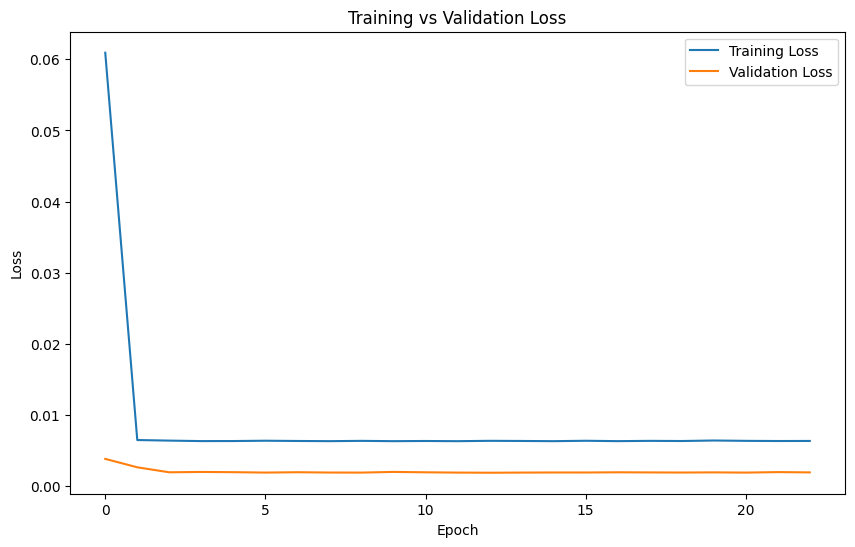

In [10]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
y_pred = model.predict(X_test)

10181/10181 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step


In [12]:
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

In [13]:
print("Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

Performance Metrics:
Mean Absolute Error (MAE): 7.16
Mean Squared Error (MSE): 822.63
Root Mean Squared Error (RMSE): 28.68
R² Score: 0.989


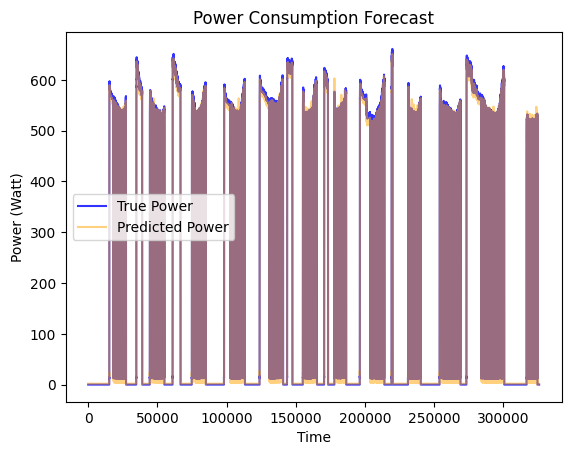

In [14]:
plt.plot(y_test_rescaled, label='True Power', color='blue', alpha=0.8)
plt.plot(y_pred_rescaled, label='Predicted Power', color='orange', alpha=0.5)
plt.legend()
plt.title("Power Consumption Forecast")
plt.xlabel("Time")
plt.ylabel("Power (Watt)")
plt.show()

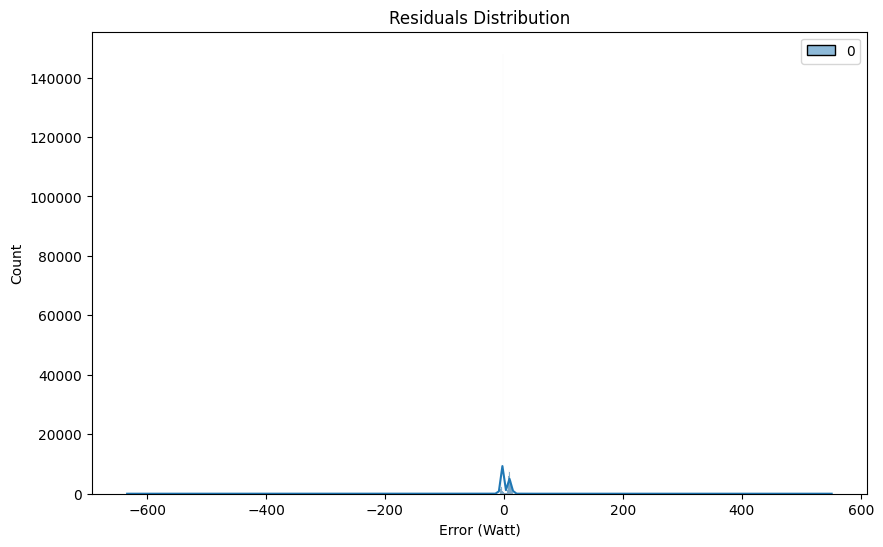

In [15]:
residuals = y_test_rescaled - y_pred_rescaled

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Error (Watt)')
plt.show()

In [16]:
result_df = pd.DataFrame({
    'time': test_data.index[24:].strftime('%Y-%m-%dT%H:%M:%S'),
    'predicted_power': y_pred_rescaled.flatten(),
    'actual_power': y_test_rescaled.flatten(),
})

In [17]:
result_df['time'] = pd.to_datetime(result_df['time'], format="ISO8601")
result_df['date'] = result_df['time'].dt.date
daily_counts = result_df.groupby(['date']).size().reset_index(name='count')
daily_counts["date"] = daily_counts["date"].astype(str)

dates = []
predicted_energy = []
actual_energy = []
different = []

for _, row in daily_counts.iterrows():
    date = row["date"]
    
    sensor_data = result_df[result_df["date"] == pd.to_datetime(date).date()]
    sensor_data = sensor_data.sort_values(by="time")
    
    sensor_data["time_diff"] = sensor_data["time"].diff().dt.total_seconds()
    average_interval = sensor_data["time_diff"].mean()
    
    total_energy_predicted = 0
    total_energy_actual = 0
    for _, row in sensor_data.iterrows():
        predicted_power = row["predicted_power"]
        actual_power = row["actual_power"]
        interval = average_interval / 3600

        predicted_energy_value = (predicted_power * interval) / 1000
        total_energy_predicted += predicted_energy_value

        actual_energy_value = (actual_power * interval) / 1000
        total_energy_actual += actual_energy_value

    dates.append(date)
    predicted_energy.append(total_energy_predicted)
    actual_energy.append(total_energy_actual)
    different.append(total_energy_actual - total_energy_predicted)

    print(f"Different energy consumption ({date}):", total_energy_actual - total_energy_predicted, "kWh")

Different energy consumption (2024-11-10): 0.028558323104143746 kWh
Different energy consumption (2024-11-11): 0.050224949590624846 kWh
Different energy consumption (2024-11-12): 0.05827449232308801 kWh
Different energy consumption (2024-11-13): 0.053567351287875375 kWh
Different energy consumption (2024-11-14): 0.07668474071994336 kWh
Different energy consumption (2024-11-15): 0.06534389975879673 kWh
Different energy consumption (2024-11-16): 0.0674109823611797 kWh
Different energy consumption (2024-11-17): 0.08095629906441815 kWh
Different energy consumption (2024-11-18): 0.001327114539659835 kWh
Different energy consumption (2024-11-19): 0.019989772577990728 kWh
Different energy consumption (2024-11-20): 0.08607874512863134 kWh
Different energy consumption (2024-11-21): 0.0007088611503367481 kWh


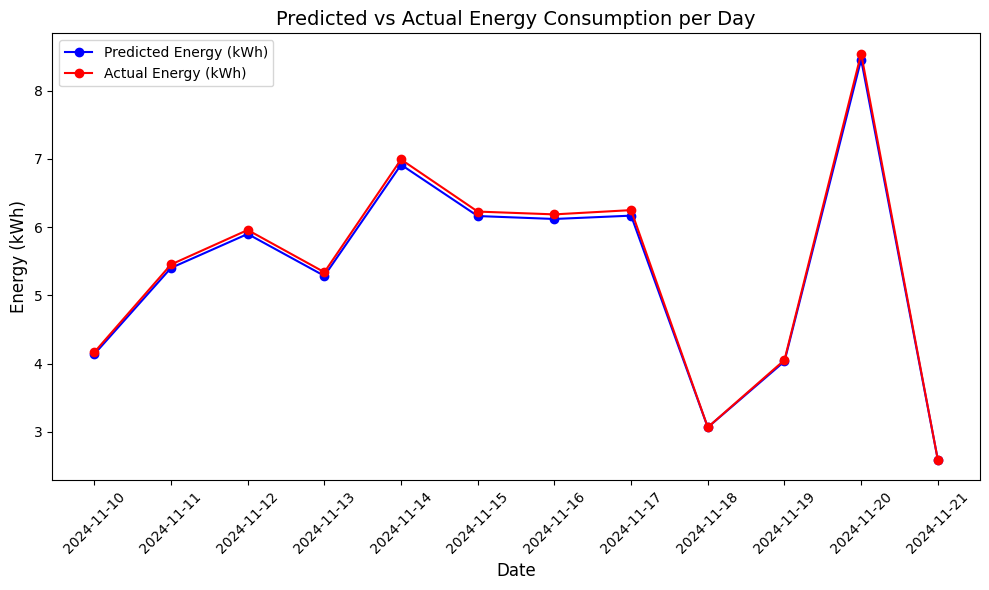

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_energy, label="Predicted Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.plot(dates, actual_energy, label="Actual Energy (kWh)", marker='o', linestyle='-', color='red')
plt.title("Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

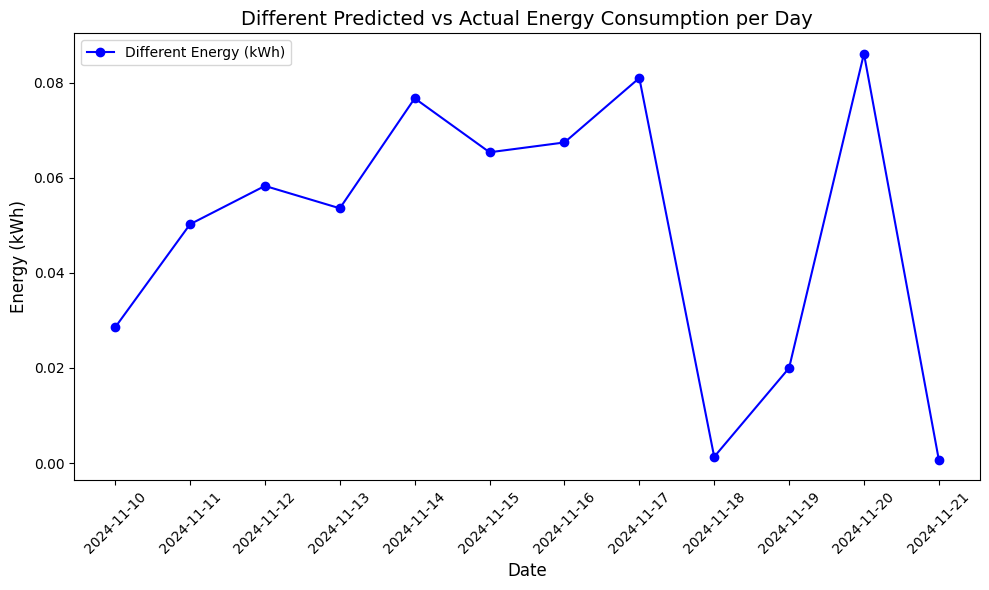

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(dates, different, label="Different Energy (kWh)", marker='o', linestyle='-', color='blue')
plt.title("Different Predicted vs Actual Energy Consumption per Day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
model.save(f"{save_folder}/{sensor_name}_model.h5")
print(f"Model saved as {sensor_name}_model.h5")

Model saved as Sensor 1_model.h5
